In this notebook, we will be exploring a modified version of a database called Chinook. This database contains information about a fictional digital music shop (similar to a mini-iTunes store), contained in 11 tables, about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases.

We will start by importing the libraries we are going to use in our mission.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

Let's define first some useful functions to help us explore the database in a more convinient way.

In [2]:
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

Let's explain the above functions:
- The `run_query()` function takes a SQL query as an argument and returns a pandas dataframe of that query,
- The `run_command()` function takes a SQL command as an argument and executes it using the sqlite modulem
- The `show_tables()` function that calls the run_query() function to return a list of all tables and views in the database.

Now, let's have a look at the tables of our database.

In [3]:
db = 'chinook.db'
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Analyzing Albums

Let's run a query to find the top 5 albums, as calculated by the number of times a track from that album has been purchased.

In [4]:
top_albums = '''SELECT tar.title album, tar.name artist, COUNT(*) tracks_purchased FROM invoice_line il
INNER JOIN (SELECT al.title, t.track_id, ar.name FROM track t
INNER JOIN album al ON al.album_id = t.album_id
INNER JOIN artist ar ON ar.artist_id = al.artist_id) tar
ON tar.track_id = il.track_id
GROUP BY 1
ORDER BY 3 DESC
LIMIT 5'''
run_query(top_albums)

,album,artist,tracks_purchased
0,Are You Experienced?,Jimi Hendrix,187
1,Faceless,Godsmack,96
2,Mezmerize,System Of A Down,93
3,Get Born,JET,90
4,The Doors,The Doors,83


Let's try to find out the top 10 genres that sell the most tracks in the USA.

In [2]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Let's visualize this result using a bar plot.

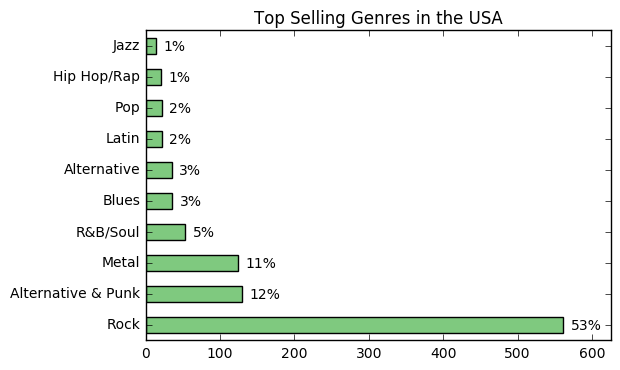

In [3]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Based on the sales of tracks across different genres in the USA, we should purchase new albums from 'rock' artists since the 'rock' genre accounts for 53% of sales.

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album. For this purpose, let's compare the number of purchases of albums compared to individual tracks.

In [6]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases.  Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.

## Analyzing Playlists

Let's run a query that shows summary data for every playlist in the Chinook database.

In [13]:
playlists='''WITH playlist_info AS
    ( SELECT
        p.playlist_id playlist_id,
        p.name playlist_name,
        t.name track_name,
        (t.milliseconds/1000) duration
      FROM playlist p
      LEFT JOIN playlist_track pt ON p.playlist_id = pt.playlist_id
      LEFT JOIN track t ON t.track_id = pt.track_id
    )
    
SELECT 
      playlist_id,
      playlist_name,
      COUNT(track_name) number_of_tracks,
      SUM(duration) length_seconds
FROM playlist_info
GROUP BY 1
ORDER BY 1'''
run_query(playlists)

,playlist_id,playlist_name,number_of_tracks,length_seconds
0,1,Music,3290,876049.0
1,2,Movies,0,NaN
2,3,TV Shows,213,500987.0
3,4,Audiobooks,0,NaN
4,5,90’s Music,1477,397970.0
5,6,Audiobooks,0,NaN
6,7,Movies,0,NaN
7,8,Music,3290,876049.0
8,9,Music Videos,1,294.0
9,10,TV Shows,213,500987.0


## Analyzing Employees

Let's run a query that returns information about each employee and their supervisor.

In [5]:
employee_supervisor='''SELECT
    e1.first_name || ' ' || e1.last_name employee_name,
    e1.title employee_title,
    e2.first_name || ' ' || e2.last_name supervisor_name,
    e2.title supervisor_title
FROM employee e1
LEFT JOIN employee e2 on e1.reports_to = e2.employee_id
ORDER BY 1'''
run_query(employee_supervisor)

,employee_name,employee_title,supervisor_name,supervisor_title
0,Andrew Adams,General Manager,None,None
1,Jane Peacock,Sales Support Agent,Nancy Edwards,Sales Manager
2,Laura Callahan,IT Staff,Michael Mitchell,IT Manager
3,Margaret Park,Sales Support Agent,Nancy Edwards,Sales Manager
4,Michael Mitchell,IT Manager,Andrew Adams,General Manager
5,Nancy Edwards,Sales Manager,Andrew Adams,General Manager
6,Robert King,IT Staff,Michael Mitchell,IT Manager
7,Steve Johnson,Sales Support Agent,Nancy Edwards,Sales Manager


Let's try to analyze the employee sales performance. We will run a query to determine the top 3 performers based on the total sales.

In [9]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1;
'''

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


We can visualize this result using a bar plot.

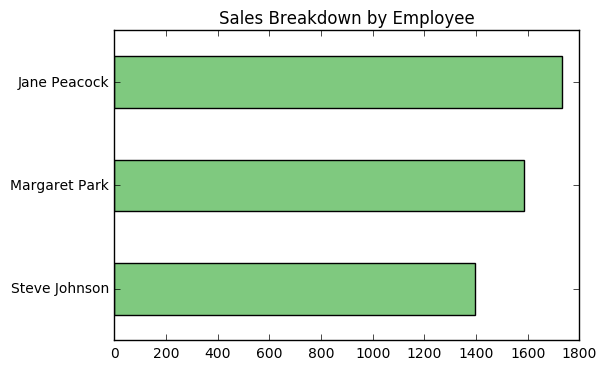

In [5]:
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

## Analyzing Customers

Imagine we have just returned from lunch to see another phone message on your desk: "Call Belle". Let's write a query that finds the contact details a customer with a `first_name` containing **Belle** from the database.

In [11]:
finding_belle='''SELECT
    first_name,
    last_name,
    phone
FROM customer
WHERE first_name LIKE "%Belle%";'''
run_query(finding_belle)

,first_name,last_name,phone
0,Isabelle,Mercier,+33 03 80 73 66 99


It turns out the person in question is Isabelle Mercier and we were able to get her phone number.

Say we wanted to gather total sales data on customers from a given country, for example India.

In [14]:
customers_india='''WITH
    customers_india AS
        (
        SELECT * FROM customer
        WHERE country = "India"
        ),
    sales_per_customer AS
        (
         SELECT
             customer_id,
             SUM(total) total
         FROM invoice
         GROUP BY 1
        )

SELECT
    ci.first_name || " " || ci.last_name customer_name,
    spc.total total_purchases
FROM customers_india ci
INNER JOIN sales_per_customer spc ON ci.customer_id = spc.customer_id
ORDER BY 1;'''
run_query(customers_india)

,customer_name,total_purchases
0,Manoj Pareek,111.87
1,Puja Srivastava,71.28


We can see that the exists only two persons from India in our database.

Now, we want to generate a report summarizing each customer purchases. It might be nice to create a column that puts each customer into a category:

- Small spender: if the customer's total purchases are less than \\$40.
- Big spender: if the customer's total purchases are greater than \\$100.
- Regular: if the customer's total purchases are between \\$40 and \\$100. 

In [12]:
customers_categories='''SELECT 
      c.first_name || ' ' || c.last_name customer_name,
      COUNT(*) number_of_purchases,
      SUM(i.total) total_spent,
      CASE
          WHEN SUM(i.total) < 40 THEN "small spender"
          WHEN SUM(i.total) > 100   THEN "big spender"
          ELSE "regular"
          END
          AS customer_category
FROM customer c
INNER JOIN invoice i
ON c.customer_id = i.customer_id
GROUP BY c.customer_id
ORDER BY customer_name'''
run_query(customers_categories)

,customer_name,number_of_purchases,total_spent,customer_category
0,Aaron Mitchell,8,70.29,regular
1,Alexandre Rocha,10,69.30,regular
2,Astrid Gruber,9,69.30,regular
3,Bjørn Hansen,9,72.27,regular
4,Camille Bernard,9,79.20,regular
5,Daan Peeters,7,60.39,regular
6,Dan Miller,12,95.04,regular
7,Diego Gutiérrez,5,39.60,small spender
8,Dominique Lefebvre,9,72.27,regular
9,Eduardo Martins,12,60.39,regular


We can clearly see that the majority of the customers are regular spenders.

Let's run a query to find out the customer from each country that has spent the most money at our store.

In [15]:
top_customer_per_country = '''WITH tp AS
    (
     SELECT c.customer_id, SUM(i.total) total_purchased
     FROM customer c
     INNER JOIN invoice i ON c.customer_id = i.customer_id
     GROUP BY c.customer_id
     )
     
SELECT 
    c.country,
    c.first_name || ' ' || c.last_name customer_name,
    MAX(tp.total_purchased) total_purchased
FROM tp 
INNER JOIN customer c ON tp.customer_id = c.customer_id
GROUP BY 1
ORDER BY 1'''
run_query(top_customer_per_country)

,country,customer_name,total_purchased
0,Argentina,Diego Gutiérrez,39.60
1,Australia,Mark Taylor,81.18
2,Austria,Astrid Gruber,69.30
3,Belgium,Daan Peeters,60.39
4,Brazil,Luís Gonçalves,108.90
5,Canada,François Tremblay,99.99
6,Chile,Luis Rojas,97.02
7,Czech Republic,František Wichterlová,144.54
8,Denmark,Kara Nielsen,37.62
9,Finland,Terhi Hämäläinen,79.20


## Analyzing Sales

We will start by analyzing the sales by country. We will run a query to show the top 10 countries in terms of total sales.

In [10]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


Le'ts plot some graphs to have a better idea about the sales by country.

C:\Users\chaouki\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


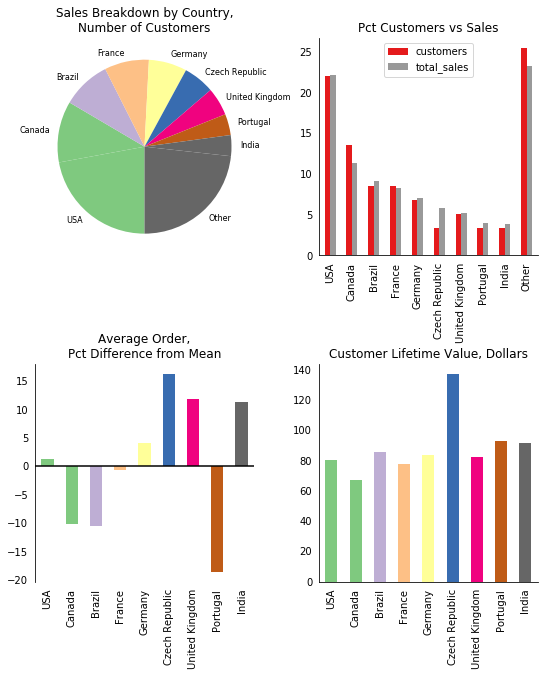

In [8]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low.  Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence.  A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.